In [1]:
#!c1.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

## Read data

In [11]:
#!c1.8
df = pd.DataFrame()
for filename in tqdm(os.listdir('./LaggedFeatures')): 
    if filename!='.ipynb_checkpoints':
        data = pd.read_csv(f'./LaggedFeatures/{filename}', sep = ',')
        df = df.append(data)

In [4]:
#!c1.8
df = df.reset_index(drop = True)

In [12]:
#!c1.8
print(df.shape)

(12002637, 140)


In [13]:
#!c1.8
df.rename(columns = {'product_rk' :'PRODUCT_RK', 'store_location_rk':'STORE_LOCATION_RK'}, inplace = True)

## Merge products

In [2]:
#!c1.8
product_dict = pd.read_csv('PRODUCT.csv', sep=';')

In [3]:
#!c1.8
prod_cols = product_dict.columns[product_dict.columns.str.contains('RK')]

In [16]:
#!c1.8
df_merged = df.merge(product_dict[prod_cols], how='left', on='PRODUCT_RK')

In [4]:
#!c1.8
loc_dict = pd.read_csv('LOCATION.csv', sep=';')

In [5]:
#!c1.8
loc_cols = loc_dict.columns[loc_dict.columns.str.contains('RK')]

In [19]:
#!c1.8
df_merged = df_merged.merge(loc_dict[loc_cols], how='left', on='STORE_LOCATION_RK')

## Clustering 

In [20]:
#!c1.8
df_merged['period_start_dt'].max()

'2019-12-30'

In [21]:
#!c1.8
df = []

In [3]:
#!c1.8
train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 91.0% of data
Test contains 9.0% of data


## By PRODUCT_LVL_RK3

In [23]:
#!c1.8
## calculate mean demand for every pair product-city

demand_loc = pd.pivot_table(df_merged_train.groupby(['STORE_LOCATION_RK', 'PRODUCT_LVL_RK3'])['demand'].mean().reset_index(), 
                                      index='STORE_LOCATION_RK', values='demand', columns='PRODUCT_LVL_RK3', fill_value=0).rename_axis(None, axis=1)
demand_loc.columns = demand_loc.columns.astype(str)
demand_loc.head()



1938      3480      3752  ...     112574    112598    113535
STORE_LOCATION_RK                            ...                               
317                 0.0  0.431750  0.237829  ...  10.225303  0.371904  0.743175
355                 0.0  0.608806  0.314096  ...  13.519663  0.371057  0.889520
380                 0.0  0.524081  0.298441  ...  14.494449  0.376492  0.763178
425                 0.0  0.603273  0.299025  ...  18.739651  0.388773  0.795932
453                 0.0  0.566113  0.304520  ...  13.654529  0.336945  0.776393

[5 rows x 33 columns]

In [24]:
#!c1.8
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [25]:
#!c1.8
## how to define number of clusters?
for i in range(3,20):
    agcl =  AgglomerativeClustering(n_clusters=i)
    cluster_labels = agcl.fit_predict(demand_loc)

    ## add labels to dataset
    demand_loc[f'label_{i}'] = cluster_labels
    df_merged = df_merged.merge(demand_loc.reset_index()[['STORE_LOCATION_RK', f'label_{i}']],
                                copy=False, on='STORE_LOCATION_RK')
df_merged = df_merged.sort_values('period_start_dt')
df_merged.head()

PRODUCT_RK  STORE_LOCATION_RK  ... label_18  label_19
0             50329               1005  ...        0         2
8089122       80110                535  ...        5         5
8089121       74855                535  ...        5         5
8089120       45592                535  ...        5         5
8089119       19350                535  ...        5         5

[5 rows x 167 columns]

In [27]:
#!c1.8
df_merged.to_parquet('merged_df_segmentation.parquet')

In [28]:
#!c1.8
demand_loc = []

In [6]:
#!c1.8
df_merged = pd.read_parquet('merged_df_segmentation.parquet')

## Predictions

### Splitting data

In [7]:
#!c1.8
## now with labels
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 91.0% of data
Test contains 9.0% of data


In [42]:
#!c1.8
lag_cols = df_merged_train.columns[df_merged_train.columns.str.contains('demand_')]
train_cols = list(lag_cols) + list(prod_cols) + list(loc_cols)

X_train, y_train = df_merged_train[train_cols], df_merged_train['demand']
X_test, y_test = df_merged_test[train_cols], df_merged_test['demand']

### No clustering

In [190]:
#!c1.8
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

cat = CatBoostRegressor()
cat.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.204254
0:	learn: 2.7245031	total: 1.1s	remaining: 18m 17s
1:	learn: 2.6579982	total: 1.99s	remaining: 16m 34s
2:	learn: 2.6100709	total: 3.02s	remaining: 16m 44s
3:	learn: 2.5706394	total: 4.09s	remaining: 16m 59s
4:	learn: 2.5431261	total: 5s	remaining: 16m 34s
5:	learn: 2.5232762	total: 6.1s	remaining: 16m 50s
6:	learn: 2.5090644	total: 7.26s	remaining: 17m 10s
7:	learn: 2.4960764	total: 8.2s	remaining: 16m 56s
8:	learn: 2.4878579	total: 9.39s	remaining: 17m 13s
9:	learn: 2.4815276	total: 10.7s	remaining: 17m 42s
10:	learn: 2.4758011	total: 11.6s	remaining: 17m 19s
11:	learn: 2.4714002	total: 12.7s	remaining: 17m 26s
12:	learn: 2.4680221	total: 14.1s	remaining: 17m 53s
13:	learn: 2.4621329	total: 15.6s	remaining: 18m 21s
14:	learn: 2.4558766	total: 16.8s	remaining: 18m 23s
15:	learn: 2.4518850	total: 17.7s	remaining: 18m 8s
16:	learn: 2.4470737	total: 18.4s	remaining: 17m 46s
17:	learn: 2.4444820	total: 19.8s	remaining: 18m 1s
18:	learn: 2.4429571	total: 21.5s	

In [191]:
#!c1.8
preds = cat.predict(X_test)

In [192]:
#!c1.8
rmse = mean_squared_error(preds, y_test, squared = False)
print('Error without clustering:', rmse)

Error without clustering: 2.57817453491539


Text(0.5, 1.0, 'Feature Importance')

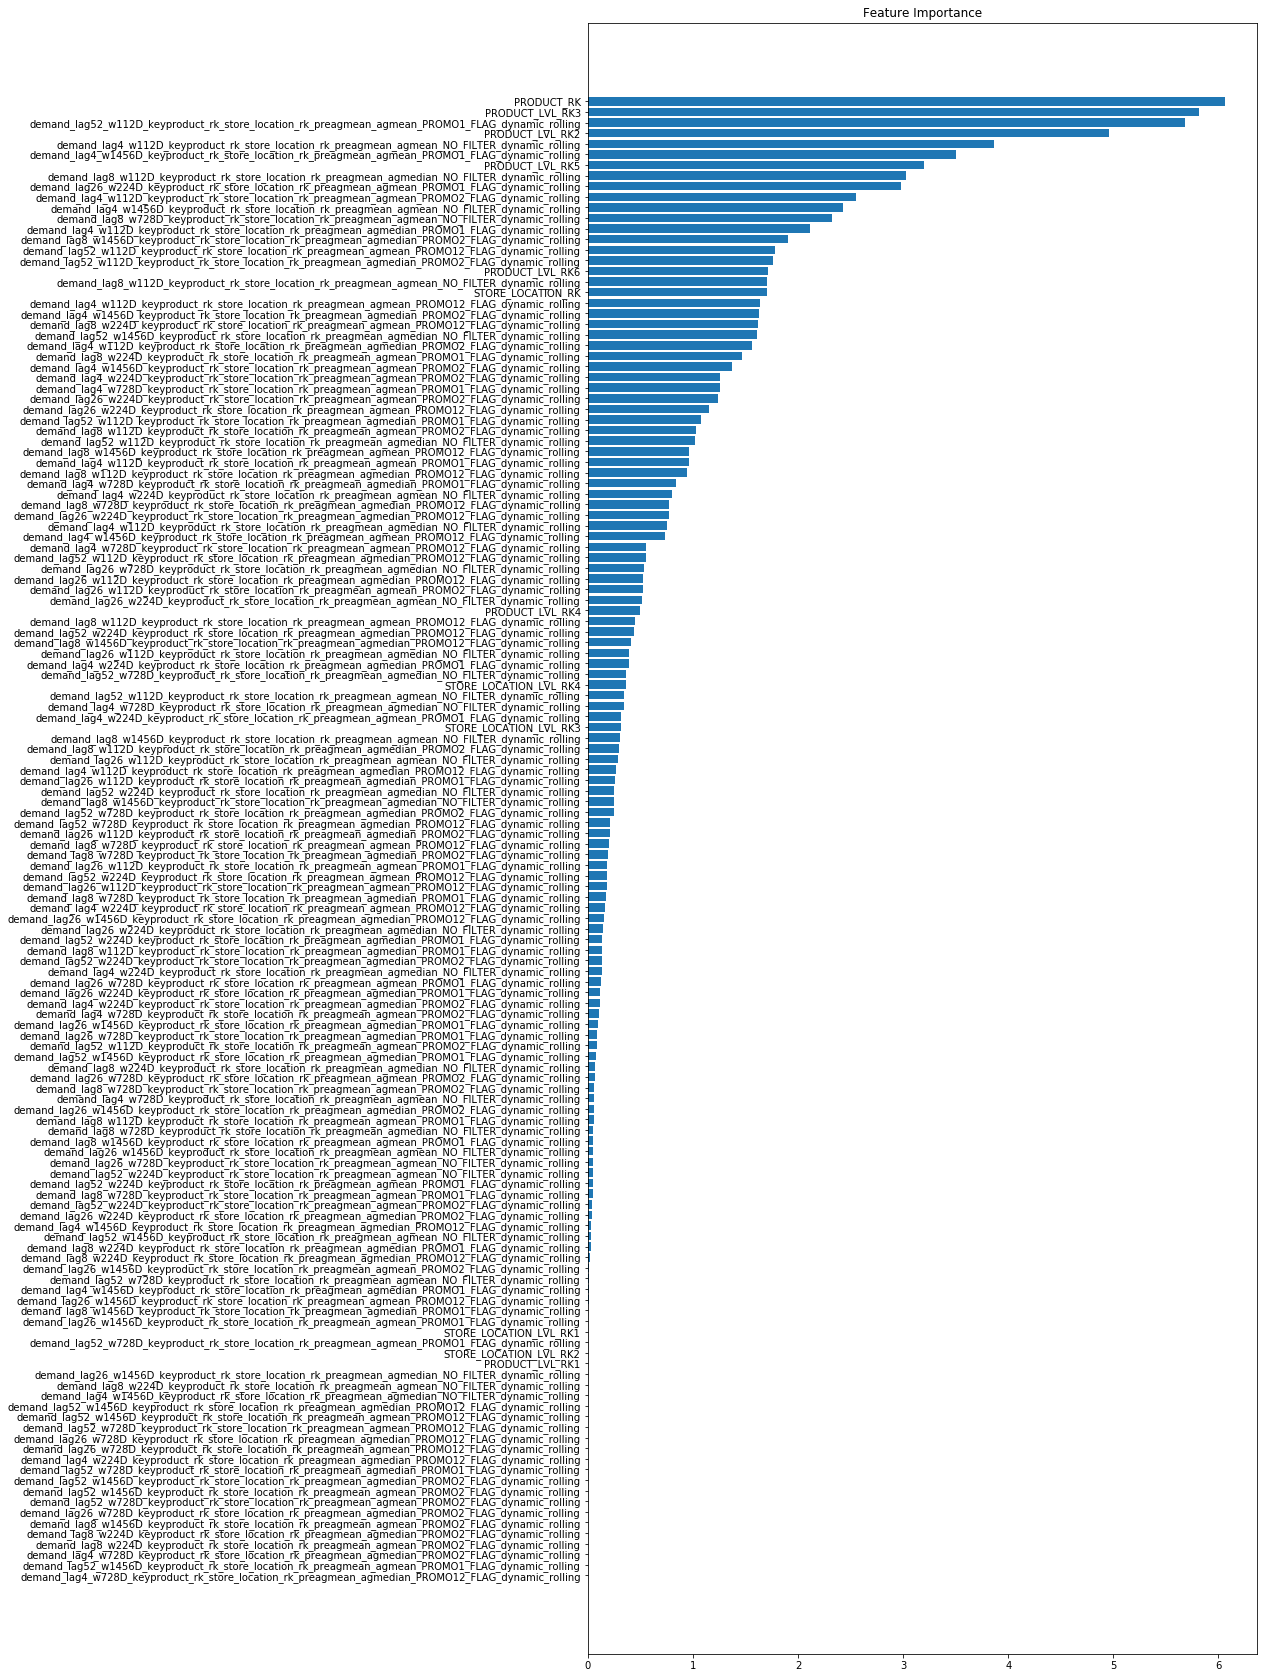

In [32]:
#!c1.8
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test[train_cols].columns)[sorted_idx])
plt.title('Feature Importance')


## On Clusters

In [19]:
#!c1.8
lag_cols = df_merged_train.columns[df_merged_train.columns.str.contains('demand_')]
train_cols = list(lag_cols) + list(prod_cols) + list(loc_cols)
X_train, y_train = df_merged_train[train_cols], df_merged_train['demand']
X_test, y_test = df_merged_test[train_cols + ['label_19']], df_merged_test[['demand','label_19']]

In [22]:
#!c1.8
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

cat = CatBoostRegressor(100)
cat.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 2.6193794	total: 1.08s	remaining: 1m 46s
1:	learn: 2.5357156	total: 2.14s	remaining: 1m 44s
2:	learn: 2.4980718	total: 3.26s	remaining: 1m 45s
3:	learn: 2.4803365	total: 4.4s	remaining: 1m 45s
4:	learn: 2.4649764	total: 5.21s	remaining: 1m 39s
5:	learn: 2.4577909	total: 6.52s	remaining: 1m 42s
6:	learn: 2.4452199	total: 7.48s	remaining: 1m 39s
7:	learn: 2.4419369	total: 8.88s	remaining: 1m 42s
8:	learn: 2.4358794	total: 10.4s	remaining: 1m 44s
9:	learn: 2.4303928	total: 11.1s	remaining: 1m 40s
10:	learn: 2.4284854	total: 12.2s	remaining: 1m 39s
11:	learn: 2.4212962	total: 13s	remaining: 1m 35s
12:	learn: 2.4164593	total: 13.7s	remaining: 1m 31s
13:	learn: 2.4110503	total: 14.4s	remaining: 1m 28s
14:	learn: 2.4046250	total: 15.1s	remaining: 1m 25s
15:	learn: 2.4034099	total: 16.1s	remaining: 1m 24s
16:	learn: 2.3978349	total: 17.2s	remaining: 1m 23s
17:	learn: 2.3959164	total: 17.9s	remaining: 1m 21s
18:	learn: 2.3932510	total: 18.8s	remaining: 1m 20s


In [23]:
#!c1.8
for label in X_test['label_19'].unique():
    preds_c = cat.predict(X_test[X_test['label_19']==label][train_cols])
    print(mean_squared_error(preds_c, y_test[y_test['label_19']==label]['demand'], squared = False))

1.5482855117100782
2.1359650285917513
2.2398543973859044
2.2950169933870734
2.194018466832509
1.4027686635466223
2.970592979095173
2.8792944819356445
1.8297855549207762
4.188407058196429
3.5154516858030194
3.5161028373946306
2.619675584624312
2.361501755202143
3.1657199653403514
2.35689357824487


### With clustering

In [9]:
#!c1.8
df_merged = []

In [17]:
#!c1.8
from itertools import chain
res = pd.DataFrame(columns = {'label', 'rmse'})
for clust in tqdm(df_merged_train.columns[df_merged_train.columns.str.contains('label')]):
    preds = []
    y_test = []
    for label in df_merged_test[clust].unique():
        y_test.append(df_merged_test[df_merged_test[clust] == label]['demand'])
        X_train, y_train = df_merged_train[df_merged_train[clust] == label][train_cols], df_merged_train[df_merged_train[clust] == label]['demand']
        X_test = df_merged_test[df_merged_test[clust] == label][train_cols]
        cat = CatBoostRegressor(100)
        cat.fit(X_train, y_train)
        preds.append(cat.predict(X_test))
    res = res.append({'label':clust, 'rmse':mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False)}, ignore_index = True)

 819ms
87:	learn: 2.3916191	total: 5.53s	remaining: 755ms
88:	learn: 2.3912429	total: 5.62s	remaining: 695ms
89:	learn: 2.3898153	total: 5.68s	remaining: 631ms
90:	learn: 2.3847105	total: 5.72s	remaining: 566ms
91:	learn: 2.3834756	total: 5.78s	remaining: 503ms
92:	learn: 2.3829369	total: 5.84s	remaining: 440ms
93:	learn: 2.3817544	total: 5.89s	remaining: 376ms
94:	learn: 2.3812508	total: 5.95s	remaining: 313ms
95:	learn: 2.3805698	total: 6s	remaining: 250ms
96:	learn: 2.3788726	total: 6.07s	remaining: 188ms
97:	learn: 2.3780189	total: 6.16s	remaining: 126ms
98:	learn: 2.3775867	total: 6.22s	remaining: 62.8ms
99:	learn: 2.3766738	total: 6.28s	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.1975964	total: 259ms	remaining: 25.6s
1:	learn: 2.1413238	total: 549ms	remaining: 26.9s
2:	learn: 2.1107986	total: 762ms	remaining: 24.7s
3:	learn: 2.0960615	total: 1.08s	remaining: 26s
4:	learn: 2.0830842	total: 1.36s	remaining: 25.8s
5:	learn: 2.0720584	total: 1.69s	remaining: 26.5s
6:	learn: 2

In [18]:
#!c1.8
res

rmse     label
0   2.620539   label_3
1   2.633903   label_4
2   2.647374   label_5
3   2.647785   label_6
4   2.642615   label_7
5   2.642664   label_8
6   2.646475   label_9
7   2.669471  label_10
8   2.671975  label_11
9   2.688001  label_12
10  2.662180  label_13
11  2.662959  label_14
12  2.641206  label_15
13  2.644229  label_16
14  2.642205  label_17
15  2.629733  label_18
16  2.652366  label_19

In [26]:
#!c1.8
for i in range((len(preds))):
    print(mean_squared_error(preds[i], y_test[i], squared = False))

1.5485795587526356
2.251370216443205
2.3647234434759588
2.2950490582678365
2.304571010593119
1.4948899592222717
3.062797536717694
3.0987827580499374
1.8415994249284973
4.154448621601106
3.4273981748975855
3.818851199706977
2.6454989206249286
2.4705795551321006
3.316204394280832
2.403939796515415


In [ ]:
#!c1.8
1.5482855117100782 
2.1359650285917513 
2.2398543973859044 
2.2950169933870734 
2.194018466832509  
1.4027686635466223
2.970592979095173 
2.8792944819356445 
1.8297855549207762
4.188407058196429 
3.5154516858030194
3.5161028373946306
2.619675584624312 
2.361501755202143 
3.1657199653403514  
2.35689357824487 

In [34]:
#!c1.8
for label in X_test['label_19'].unique():
    print(X_test[X_test['label_19']==label].shape[0])

82106
48101
76481
182144
77056
40260
70862
65809
102635
74899
46504
41884
56576
47235
21364
53444


In [10]:
#!c1.8
for label in df_merged_test['label_19'].unique():
    print(f'{label} - {df_merged_train[df_merged_train.label_19==label].shape[0]}')

0 - 923861
16 - 583135
11 - 802394
1 - 1824048
7 - 759309
5 - 447422
9 - 320027
15 - 390997
17 - 1132320
13 - 375596
2 - 981532
18 - 410200
10 - 569277
6 - 267991
4 - 40069
3 - 600408


# clustering on store_location_rk


In [8]:
#!c1.8
lag_cols = df_merged_train.columns[df_merged_train.columns.str.contains('demand_')]
train_cols = list(lag_cols) + list(prod_cols) + list(loc_cols)

In [202]:
#!c1.8
from itertools import chain
preds = []
y_test = []
for label in df_merged_test['STORE_LOCATION_RK'].unique():
    y_test.append(df_merged_test[df_merged_test['STORE_LOCATION_RK'] == label]['demand'])
    X_train, y_train = df_merged_train[df_merged_train['STORE_LOCATION_RK'] == label][train_cols], df_merged_train[df_merged_train['STORE_LOCATION_RK'] == label]['demand']
    X_test = df_merged_test[df_merged_test['STORE_LOCATION_RK'] == label][train_cols]
    cat = CatBoostRegressor(100)
    cat.fit(X_train, y_train)
    preds.append(cat.predict(X_test))
print(mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False))

Learning rate set to 0.5
0:	learn: 2.4552638	total: 96.7ms	remaining: 9.58s
1:	learn: 2.3821491	total: 138ms	remaining: 6.78s
2:	learn: 2.3365341	total: 183ms	remaining: 5.93s
3:	learn: 2.3109254	total: 216ms	remaining: 5.18s
4:	learn: 2.3022863	total: 265ms	remaining: 5.04s
5:	learn: 2.2392593	total: 294ms	remaining: 4.61s
6:	learn: 2.2221025	total: 332ms	remaining: 4.42s
7:	learn: 2.2069323	total: 381ms	remaining: 4.38s
8:	learn: 2.1919107	total: 413ms	remaining: 4.18s
9:	learn: 2.1530578	total: 439ms	remaining: 3.95s
10:	learn: 2.1507263	total: 482ms	remaining: 3.9s
11:	learn: 2.1281567	total: 510ms	remaining: 3.74s
12:	learn: 2.1073946	total: 535ms	remaining: 3.58s
13:	learn: 2.0987835	total: 582ms	remaining: 3.58s
14:	learn: 2.0742059	total: 625ms	remaining: 3.54s
15:	learn: 2.0605071	total: 663ms	remaining: 3.48s
16:	learn: 2.0538839	total: 704ms	remaining: 3.44s
17:	learn: 2.0477319	total: 743ms	remaining: 3.38s
18:	learn: 2.0405007	total: 786ms	remaining: 3.35s
19:	learn: 2.027

In [204]:
#!c1.8
from itertools import chain
preds = []
y_test = []
for label in df_merged_test['PRODUCT_LVL_RK3'].unique():
    y_test.append(df_merged_test[df_merged_test['PRODUCT_LVL_RK3'] == label]['demand'])
    X_train, y_train = df_merged_train[df_merged_train['PRODUCT_LVL_RK3'] == label][train_cols], df_merged_train[df_merged_train['PRODUCT_LVL_RK3'] == label]['demand']
    X_test = df_merged_test[df_merged_test['PRODUCT_LVL_RK3'] == label][train_cols]
    cat = CatBoostRegressor(100)
    cat.fit(X_train, y_train)
    preds.append(cat.predict(X_test))
print(mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False))

Learning rate set to 0.5
0:	learn: 0.7812780	total: 43.9ms	remaining: 4.35s
1:	learn: 0.7532630	total: 85.4ms	remaining: 4.19s
2:	learn: 0.7416571	total: 128ms	remaining: 4.13s
3:	learn: 0.7361654	total: 173ms	remaining: 4.16s
4:	learn: 0.7319461	total: 211ms	remaining: 4s
5:	learn: 0.7279728	total: 248ms	remaining: 3.89s
6:	learn: 0.7252034	total: 295ms	remaining: 3.92s
7:	learn: 0.7227502	total: 340ms	remaining: 3.91s
8:	learn: 0.7205949	total: 381ms	remaining: 3.85s
9:	learn: 0.7189696	total: 424ms	remaining: 3.82s
10:	learn: 0.7178539	total: 464ms	remaining: 3.75s
11:	learn: 0.7161172	total: 501ms	remaining: 3.67s
12:	learn: 0.7144677	total: 532ms	remaining: 3.56s
13:	learn: 0.7134317	total: 572ms	remaining: 3.51s
14:	learn: 0.7125666	total: 620ms	remaining: 3.51s
15:	learn: 0.7103794	total: 666ms	remaining: 3.49s
16:	learn: 0.7092707	total: 697ms	remaining: 3.4s
17:	learn: 0.7082431	total: 737ms	remaining: 3.36s
18:	learn: 0.7071516	total: 796ms	remaining: 3.39s
19:	learn: 0.70411

In [236]:
#!c1.8
from itertools import chain
preds = []
y_test = []
for label in df_merged_test['PRODUCT_LVL_RK2'].unique():
    y_test.append(df_merged_test[df_merged_test['PRODUCT_LVL_RK2'] == label]['demand'])
    X_train, y_train = df_merged_train[df_merged_train['PRODUCT_LVL_RK2'] == label][train_cols], df_merged_train[df_merged_train['PRODUCT_LVL_RK2'] == label]['demand']
    X_test = df_merged_test[df_merged_test['PRODUCT_LVL_RK2'] == label][train_cols]
    cat = CatBoostRegressor(100)
    cat.fit(X_train, y_train)
    preds.append(cat.predict(X_test))
print(mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False))

Learning rate set to 0.5
0:	learn: 1.3881441	total: 238ms	remaining: 23.6s
1:	learn: 1.3434252	total: 443ms	remaining: 21.7s
2:	learn: 1.3199942	total: 634ms	remaining: 20.5s
3:	learn: 1.3098718	total: 843ms	remaining: 20.2s
4:	learn: 1.3033253	total: 1.04s	remaining: 19.7s
5:	learn: 1.2996422	total: 1.21s	remaining: 18.9s
6:	learn: 1.2970306	total: 1.42s	remaining: 18.9s
7:	learn: 1.2911803	total: 1.58s	remaining: 18.2s
8:	learn: 1.2890461	total: 1.77s	remaining: 17.9s
9:	learn: 1.2860974	total: 2.04s	remaining: 18.4s
10:	learn: 1.2842066	total: 2.26s	remaining: 18.3s
11:	learn: 1.2829218	total: 2.51s	remaining: 18.4s
12:	learn: 1.2813523	total: 2.64s	remaining: 17.7s
13:	learn: 1.2794449	total: 2.79s	remaining: 17.2s
14:	learn: 1.2778796	total: 2.92s	remaining: 16.5s
15:	learn: 1.2764638	total: 3.18s	remaining: 16.7s
16:	learn: 1.2747411	total: 3.36s	remaining: 16.4s
17:	learn: 1.2732173	total: 3.57s	remaining: 16.3s
18:	learn: 1.2721982	total: 3.7s	remaining: 15.8s
19:	learn: 1.2715

# Кластеризация по product_rk


In [10]:
#!c1.8
## calculate mean demand for every pair product-city

demand_loc = pd.pivot_table(df_merged_train.groupby(['PRODUCT_RK'])['demand'].mean().reset_index(), 
                                      index='PRODUCT_RK', values='demand', fill_value=0).rename_axis(None, axis=1)
demand_loc.columns = demand_loc.columns.astype(str)
demand_loc.head()



demand
PRODUCT_RK          
11389       1.095238
11390       0.248875
11391       0.267311
11403       0.220466
11404       0.588613

In [13]:
#!c1.8
df_merged_train = df_merged_train[df_merged_train.columns.drop(list(df_merged_train.filter(regex='label')))]

In [14]:
#!c1.8
df_merged_test = df_merged_test[df_merged_test.columns.drop(list(df_merged_test.filter(regex='label')))]

In [14]:
#!c1.8
df_merged_train.head()

PRODUCT_RK  ...  STORE_LOCATION_LVL_RK1
0             50329  ...                       1
8089122       80110  ...                       1
8089121       74855  ...                       1
8089120       45592  ...                       1
8089119       19350  ...                       1

[5 rows x 150 columns]

In [15]:
#!c1.8
from sklearn.cluster import AgglomerativeClustering
for i in tqdm(range(10,100,10)):
    agcl =  AgglomerativeClustering(n_clusters=i)
    cluster_labels = agcl.fit_predict(demand_loc)

    ## add labels to dataset
    demand_loc[f'label_{i}'] = cluster_labels
    df_merged_train = df_merged_train.merge(demand_loc.reset_index()[['PRODUCT_RK', f'label_{i}']],
                                copy=False, on='PRODUCT_RK')
    df_merged_test = df_merged_test.merge(demand_loc.reset_index()[['PRODUCT_RK',  f'label_{i}']],
                                copy=False, on='PRODUCT_RK')
df_merged_train = df_merged_train.sort_values('period_start_dt')
df_merged_test = df_merged_test.sort_values('period_start_dt')
df_merged_test.head()

PRODUCT_RK  STORE_LOCATION_RK  ... label_80  label_90
0            77180                798  ...        1        82
890930      102721               1316  ...       43        23
890929      102721                562  ...       43        23
890918      102651                562  ...       54         6
291273      118067                866  ...        8         8

[5 rows x 159 columns]

In [235]:
#!c1.8
from itertools import chain
preds = []
y_test = []
for label in df_merged_test['label'].unique():
    y_test.append(df_merged_test[df_merged_test['label'] == label]['demand'])
    X_train, y_train = df_merged_train[df_merged_train['label'] == label][train_cols], df_merged_train[df_merged_train['label'] == label]['demand']
    X_test = df_merged_test[df_merged_test['label'] == label][train_cols]
    cat = CatBoostRegressor(100)
    cat.fit(X_train, y_train)
    preds.append(cat.predict(X_test))
print(mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False))

Learning rate set to 0.5
0:	learn: 0.2978621	total: 211ms	remaining: 20.9s
1:	learn: 0.2901558	total: 417ms	remaining: 20.4s
2:	learn: 0.2873531	total: 595ms	remaining: 19.2s
3:	learn: 0.2856993	total: 767ms	remaining: 18.4s
4:	learn: 0.2845849	total: 977ms	remaining: 18.6s
5:	learn: 0.2840085	total: 1.18s	remaining: 18.5s
6:	learn: 0.2833367	total: 1.32s	remaining: 17.5s
7:	learn: 0.2829024	total: 1.48s	remaining: 17s
8:	learn: 0.2826064	total: 1.66s	remaining: 16.8s
9:	learn: 0.2822961	total: 1.83s	remaining: 16.5s
10:	learn: 0.2820148	total: 2.07s	remaining: 16.8s
11:	learn: 0.2817386	total: 2.29s	remaining: 16.8s
12:	learn: 0.2815107	total: 2.44s	remaining: 16.3s
13:	learn: 0.2813151	total: 2.6s	remaining: 16s
14:	learn: 0.2811000	total: 2.75s	remaining: 15.6s
15:	learn: 0.2809703	total: 2.91s	remaining: 15.3s
16:	learn: 0.2808104	total: 3.15s	remaining: 15.4s
17:	learn: 0.2805571	total: 3.4s	remaining: 15.5s
18:	learn: 0.2803739	total: 3.58s	remaining: 15.3s
19:	learn: 0.2800817	t

In [16]:
#!c1.8
from itertools import chain
res = pd.DataFrame(columns = {'label', 'rmse'})
for clust in tqdm(df_merged_train.columns[df_merged_train.columns.str.contains('label')]):
    preds = []
    y_test = []
    for label in df_merged_test[clust].unique():
        y_test.append(df_merged_test[df_merged_test[clust] == label]['demand'])
        X_train, y_train = df_merged_train[df_merged_train[clust] == label][train_cols], df_merged_train[df_merged_train[clust] == label]['demand']
        X_test = df_merged_test[df_merged_test[clust] == label][train_cols]
        cat = CatBoostRegressor(100)
        cat.fit(X_train, y_train)
        preds.append(cat.predict(X_test))
    res = res.append({'label':clust, 'rmse':mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False)}, ignore_index = True)

 550ms	remaining: 646ms
46:	learn: 3.9889990	total: 562ms	remaining: 634ms
47:	learn: 3.9854251	total: 572ms	remaining: 620ms
48:	learn: 3.9782971	total: 583ms	remaining: 607ms
49:	learn: 3.9707452	total: 594ms	remaining: 594ms
50:	learn: 3.9621766	total: 607ms	remaining: 583ms
51:	learn: 3.9568199	total: 617ms	remaining: 570ms
52:	learn: 3.9496142	total: 628ms	remaining: 557ms
53:	learn: 3.9406788	total: 640ms	remaining: 545ms
54:	learn: 3.9322928	total: 651ms	remaining: 533ms
55:	learn: 3.9279743	total: 662ms	remaining: 520ms
56:	learn: 3.9241703	total: 672ms	remaining: 507ms
57:	learn: 3.9212430	total: 683ms	remaining: 494ms
58:	learn: 3.9153597	total: 699ms	remaining: 485ms
59:	learn: 3.9108063	total: 714ms	remaining: 476ms
60:	learn: 3.9065043	total: 725ms	remaining: 464ms
61:	learn: 3.9027247	total: 736ms	remaining: 451ms
62:	learn: 3.8964142	total: 748ms	remaining: 439ms
63:	learn: 3.8922321	total: 757ms	remaining: 426ms
64:	learn: 3.8855907	total: 768ms	remaining: 413ms
65:	lea

In [17]:
#!c1.8
res

label      rmse
0  label_10  2.236958
1  label_20  2.229610
2  label_30  2.141435
3  label_40  2.167921
4  label_50  2.196824
5  label_60  2.198132
6  label_70  2.201140
7  label_80  2.215952
8  label_90  2.232142

# clustering by product_lvl_rk2

In [28]:
#!c1.8
## calculate mean demand for every pair product-city

demand_loc = pd.pivot_table(df_merged_train.groupby(['PRODUCT_LVL_RK2'])['demand'].mean().reset_index(), 
                                      index='PRODUCT_LVL_RK2', values='demand', fill_value=0).rename_axis(None, axis=1)
demand_loc.columns = demand_loc.columns.astype(str)
demand_loc.head()



demand
PRODUCT_LVL_RK2          
3427             0.639081
4658             1.248579
4712             1.601378
5677             0.473459
6798             1.651941

In [29]:
#!c1.8
demand_loc.shape[0]

22

In [30]:
#!c1.8
df_merged_train = df_merged_train[df_merged_train.columns.drop(list(df_merged_train.filter(regex='label')))]

In [31]:
#!c1.8
df_merged_test = df_merged_test[df_merged_test.columns.drop(list(df_merged_test.filter(regex='label')))]

In [32]:
#!c1.8
from sklearn.cluster import AgglomerativeClustering
for i in tqdm(range(3,15)):
    agcl =  AgglomerativeClustering(n_clusters=i)
    cluster_labels = agcl.fit_predict(demand_loc)

    ## add labels to dataset
    demand_loc[f'label_{i}'] = cluster_labels
    df_merged_train = df_merged_train.merge(demand_loc.reset_index()[['PRODUCT_LVL_RK2', f'label_{i}']],
                                copy=False, on='PRODUCT_LVL_RK2')
    df_merged_test = df_merged_test.merge(demand_loc.reset_index()[['PRODUCT_LVL_RK2',  f'label_{i}']],
                                copy=False, on='PRODUCT_LVL_RK2')
df_merged_train = df_merged_train.sort_values('period_start_dt')
df_merged_test = df_merged_test.sort_values('period_start_dt')
df_merged_test.head()

PRODUCT_RK  STORE_LOCATION_RK  ... label_13  label_14
0            77180                798  ...        6         6
191906       45808                317  ...        3         5
191905       92898               1347  ...        3         5
191904       54739               1347  ...        3         5
191903       54739               1034  ...        3         5

[5 rows x 162 columns]

In [33]:
#!c1.32
from itertools import chain
res = pd.DataFrame(columns = {'label', 'rmse'})
for clust in tqdm(df_merged_train.columns[df_merged_train.columns.str.contains('label')]):
    preds = []
    y_test = []
    for label in df_merged_test[clust].unique():
        y_test.append(df_merged_test[df_merged_test[clust] == label]['demand'])
        X_train, y_train = df_merged_train[df_merged_train[clust] == label][train_cols], df_merged_train[df_merged_train[clust] == label]['demand']
        X_test = df_merged_test[df_merged_test[clust] == label][train_cols]
        cat = CatBoostRegressor(100)
        cat.fit(X_train, y_train)
        preds.append(cat.predict(X_test))
    res = res.append({'label':clust, 'rmse':mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False)}, ignore_index = True)

total: 903ms	remaining: 2.71s
25:	learn: 4.5222917	total: 932ms	remaining: 2.65s
26:	learn: 4.5134056	total: 960ms	remaining: 2.6s
27:	learn: 4.5081988	total: 982ms	remaining: 2.52s
28:	learn: 4.4972794	total: 1.01s	remaining: 2.47s
29:	learn: 4.4886955	total: 1.04s	remaining: 2.43s
30:	learn: 4.4848942	total: 1.07s	remaining: 2.39s
31:	learn: 4.4783443	total: 1.11s	remaining: 2.35s
32:	learn: 4.4710791	total: 1.15s	remaining: 2.33s
33:	learn: 4.4664003	total: 1.18s	remaining: 2.29s
34:	learn: 4.4604123	total: 1.22s	remaining: 2.26s
35:	learn: 4.4528175	total: 1.24s	remaining: 2.21s
36:	learn: 4.4472055	total: 1.27s	remaining: 2.16s
37:	learn: 4.4418226	total: 1.3s	remaining: 2.13s
38:	learn: 4.4364885	total: 1.34s	remaining: 2.09s
39:	learn: 4.4325764	total: 1.37s	remaining: 2.05s
40:	learn: 4.4301511	total: 1.4s	remaining: 2.02s
41:	learn: 4.4246648	total: 1.44s	remaining: 1.98s
42:	learn: 4.4148163	total: 1.48s	remaining: 1.96s
43:	learn: 4.4088312	total: 1.51s	remaining: 1.92s
44:	

In [34]:
#!c1.32
res

label      rmse
0    label_3  2.134697
1    label_4  2.144947
2    label_5  2.144781
3    label_6  2.158346
4    label_7  2.155040
5    label_8  2.155099
6    label_9  2.157659
7   label_10  2.157705
8   label_11  2.157716
9   label_12  2.159149
10  label_13  2.159260
11  label_14  2.162857

In [36]:
#!c1.32
## calculate mean demand for every pair product-city

demand_loc = pd.pivot_table(df_merged_train.groupby(['STORE_LOCATION_RK', 'PRODUCT_LVL_RK2'])['demand'].mean().reset_index(), 
                                      index='STORE_LOCATION_RK', values='demand', columns='PRODUCT_LVL_RK2', fill_value=0).rename_axis(None, axis=1)
demand_loc.columns = demand_loc.columns.astype(str)
demand_loc.head()


3427      4658      4712  ...    112579    112594    113534
STORE_LOCATION_RK                                ...                              
317                0.000000  0.857008  1.231591  ...  1.563540  0.669020  0.743175
355                0.000000  1.245314  1.565067  ...  1.951281  0.783681  0.889520
380                0.376775  0.921757  1.352205  ...  1.638058  0.674988  0.763178
425                0.000000  1.222530  1.547213  ...  1.887312  0.657850  0.795932
453                0.375671  1.015628  1.444004  ...  1.998232  0.703340  0.776393

[5 rows x 22 columns]

In [37]:
#!c1.32
df_merged_train = df_merged_train[df_merged_train.columns.drop(list(df_merged_train.filter(regex='label')))]

In [38]:
#!c1.32
df_merged_test = df_merged_test[df_merged_test.columns.drop(list(df_merged_test.filter(regex='label')))]

In [39]:
#!c1.32
from sklearn.cluster import AgglomerativeClustering
for i in tqdm(range(3,15)):
    agcl =  AgglomerativeClustering(n_clusters=i)
    cluster_labels = agcl.fit_predict(demand_loc)

    ## add labels to dataset
    demand_loc[f'label_{i}'] = cluster_labels
    df_merged_train = df_merged_train.merge(demand_loc.reset_index()[['STORE_LOCATION_RK', f'label_{i}']],
                                copy=False, on='STORE_LOCATION_RK')
    df_merged_test = df_merged_test.merge(demand_loc.reset_index()[['STORE_LOCATION_RK',  f'label_{i}']],
                                copy=False, on='STORE_LOCATION_RK')
df_merged_train = df_merged_train.sort_values('period_start_dt')
df_merged_test = df_merged_test.sort_values('period_start_dt')
df_merged_test.head()

PRODUCT_RK  STORE_LOCATION_RK  ... label_13  label_14
0            77180                798  ...        4         5
669763       95623                562  ...        5         6
669764       75852                562  ...        5         6
669765       24144                562  ...        5         6
669766       99251                562  ...        5         6

[5 rows x 162 columns]

In [40]:
#!c1.32
from itertools import chain
res = pd.DataFrame(columns = {'label', 'rmse'})
for clust in tqdm(df_merged_train.columns[df_merged_train.columns.str.contains('label')]):
    preds = []
    y_test = []
    for label in df_merged_test[clust].unique():
        y_test.append(df_merged_test[df_merged_test[clust] == label]['demand'])
        X_train, y_train = df_merged_train[df_merged_train[clust] == label][train_cols], df_merged_train[df_merged_train[clust] == label]['demand']
        X_test = df_merged_test[df_merged_test[clust] == label][train_cols]
        cat = CatBoostRegressor(100)
        cat.fit(X_train, y_train)
        preds.append(cat.predict(X_test))
    res = res.append({'label':clust, 'rmse':mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False)}, ignore_index = True)

 963ms
91:	learn: 2.0719452	total: 9.89s	remaining: 860ms
92:	learn: 2.0708778	total: 10s	remaining: 753ms
93:	learn: 2.0702209	total: 10.1s	remaining: 647ms
94:	learn: 2.0682686	total: 10.2s	remaining: 538ms
95:	learn: 2.0679860	total: 10.4s	remaining: 432ms
96:	learn: 2.0669383	total: 10.5s	remaining: 324ms
97:	learn: 2.0649201	total: 10.6s	remaining: 216ms
98:	learn: 2.0635629	total: 10.7s	remaining: 108ms
99:	learn: 2.0620537	total: 10.7s	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.0934698	total: 324ms	remaining: 32.1s
1:	learn: 2.0335002	total: 498ms	remaining: 24.4s
2:	learn: 2.0051761	total: 604ms	remaining: 19.5s
3:	learn: 1.9908469	total: 750ms	remaining: 18s
4:	learn: 1.9822261	total: 867ms	remaining: 16.5s
5:	learn: 1.9733514	total: 980ms	remaining: 15.3s
6:	learn: 1.9695170	total: 1.14s	remaining: 15.1s
7:	learn: 1.9639675	total: 1.28s	remaining: 14.8s
8:	learn: 1.9558525	total: 1.4s	remaining: 14.1s
9:	learn: 1.9464415	total: 1.51s	remaining: 13.6s
10:	learn: 1.943

In [41]:
#!c1.32
res

label      rmse
0    label_3  2.190658
1    label_4  2.167583
2    label_5  2.177938
3    label_6  2.177188
4    label_7  2.187741
5    label_8  2.171807
6    label_9  2.167583
7   label_10  2.173996
8   label_11  2.171165
9   label_12  2.179994
10  label_13  2.189158
11  label_14  2.207280

In [43]:
#!c1.32
## calculate mean demand for every pair product-city

demand_loc = pd.pivot_table(df_merged_train.groupby(['STORE_LOCATION_RK', 'PRODUCT_RK'])['demand'].mean().reset_index(), 
                                      index='STORE_LOCATION_RK', values='demand', columns='PRODUCT_RK', fill_value=0).rename_axis(None, axis=1)
demand_loc.columns = demand_loc.columns.astype(str)
demand_loc.head()


11389  11390  11391  ...  148271  148299  148300
STORE_LOCATION_RK                       ...                        
317                  0.0    0.0    0.0  ...       0       0       0
355                  0.0    0.0    0.0  ...       0       0       0
380                  0.0    0.0    0.0  ...       0       0       0
425                  0.0    0.0    0.0  ...       0       0       1
453                  0.0    0.0    0.0  ...       0       1       0

[5 rows x 36756 columns]

In [44]:
#!c1.32
df_merged_train = df_merged_train[df_merged_train.columns.drop(list(df_merged_train.filter(regex='label')))]

In [45]:
#!c1.32
df_merged_test = df_merged_test[df_merged_test.columns.drop(list(df_merged_test.filter(regex='label')))]

In [47]:
#!c1.32
from sklearn.cluster import AgglomerativeClustering
for i in tqdm(range(3,15)):
    agcl =  AgglomerativeClustering(n_clusters=i)
    cluster_labels = agcl.fit_predict(demand_loc)

    ## add labels to dataset
    demand_loc[f'label_{i}'] = cluster_labels
    df_merged_train = df_merged_train.merge(demand_loc.reset_index()[['STORE_LOCATION_RK', f'label_{i}']],
                                copy=False, on='STORE_LOCATION_RK')
    df_merged_test = df_merged_test.merge(demand_loc.reset_index()[['STORE_LOCATION_RK',  f'label_{i}']],
                                copy=False, on='STORE_LOCATION_RK')
df_merged_train = df_merged_train.sort_values('period_start_dt')
df_merged_test = df_merged_test.sort_values('period_start_dt')
df_merged_test.head()

PRODUCT_RK  STORE_LOCATION_RK  ... label_13  label_14
0            77180                798  ...        4         4
333601      132112                657  ...        1         0
333602      129480                657  ...        1         0
333603       21199                657  ...        1         0
333604      103754                657  ...        1         0

[5 rows x 162 columns]

In [48]:
#!c1.32
from itertools import chain
res = pd.DataFrame(columns = {'label', 'rmse'})
for clust in tqdm(df_merged_train.columns[df_merged_train.columns.str.contains('label')]):
    preds = []
    y_test = []
    for label in df_merged_test[clust].unique():
        y_test.append(df_merged_test[df_merged_test[clust] == label]['demand'])
        X_train, y_train = df_merged_train[df_merged_train[clust] == label][train_cols], df_merged_train[df_merged_train[clust] == label]['demand']
        X_test = df_merged_test[df_merged_test[clust] == label][train_cols]
        cat = CatBoostRegressor(100)
        cat.fit(X_train, y_train)
        preds.append(cat.predict(X_test))
    res = res.append({'label':clust, 'rmse':mean_squared_error(list(chain(*preds)), list(chain(*y_test)), squared = False)}, ignore_index = True)

Learning rate set to 0.5
0:	learn: 2.6605139	total: 368ms	remaining: 36.4s
1:	learn: 2.5880964	total: 602ms	remaining: 29.5s
2:	learn: 2.5555229	total: 865ms	remaining: 28s
3:	learn: 2.5406060	total: 1.14s	remaining: 27.3s
4:	learn: 2.5337457	total: 1.47s	remaining: 27.9s
5:	learn: 2.5229434	total: 2.01s	remaining: 31.5s
6:	learn: 2.5076145	total: 3.16s	remaining: 42s
7:	learn: 2.4969109	total: 3.33s	remaining: 38.3s
8:	learn: 2.4940209	total: 3.63s	remaining: 36.7s
9:	learn: 2.4870726	total: 3.95s	remaining: 35.5s
10:	learn: 2.4846725	total: 4.16s	remaining: 33.7s
11:	learn: 2.4810000	total: 4.42s	remaining: 32.4s
12:	learn: 2.4790371	total: 4.6s	remaining: 30.8s
13:	learn: 2.4763390	total: 4.78s	remaining: 29.4s
14:	learn: 2.4707029	total: 4.94s	remaining: 28s
15:	learn: 2.4691929	total: 5.26s	remaining: 27.6s
16:	learn: 2.4643280	total: 5.45s	remaining: 26.6s
17:	learn: 2.4544918	total: 5.61s	remaining: 25.5s
18:	learn: 2.4529683	total: 5.81s	remaining: 24.8s
19:	learn: 2.4514050	to

In [49]:
#!c1.32
res

rmse     label
0   2.261293   label_3
1   2.269420   label_4
2   2.347375   label_5
3   2.306709   label_6
4   2.254698   label_7
5   2.254037   label_8
6   2.258017   label_9
7   2.192159  label_10
8   2.206513  label_11
9   2.232264  label_12
10  2.234779  label_13
11  2.239860  label_14

In [ ]:
#!c1.32
